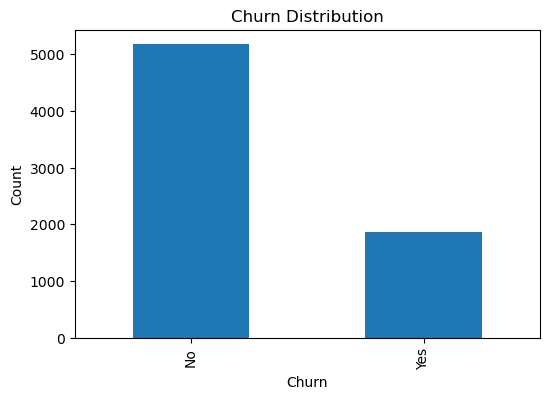

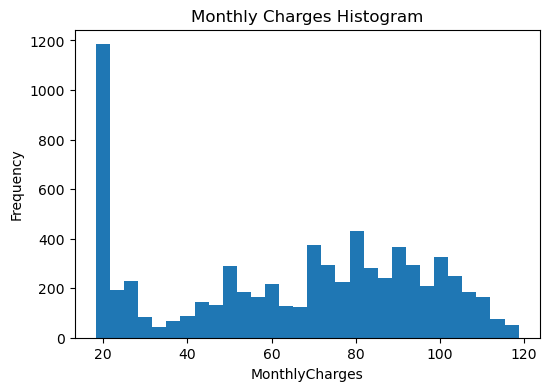

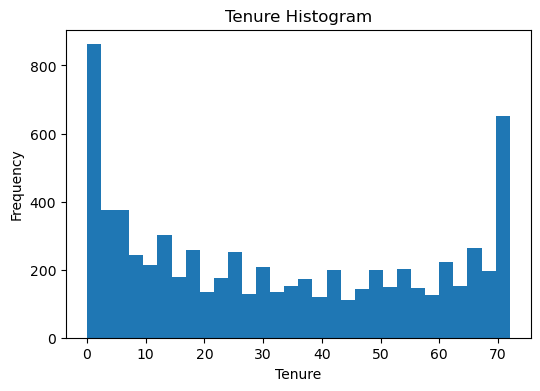


Running Random Forest randomized search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Running LightGBM randomized search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Number of positive: 2069, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1573
[LightGBM] [Info] Number of data points in the train set: 6208, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333280 -> initscore=-0.693389
[LightGBM] [Info] Start training from score -0.693389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

In [1]:
import sys
from pathlib import Path
import pandas as pd

# Project root (notebook is inside /notebooks)
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# Create results directory
GRAPHS_DIR = PROJECT_ROOT / "results" / "graphs"
GRAPHS_DIR.mkdir(parents=True, exist_ok=True)

from src.eda import run_eda
from src.preprocess import preprocess
from src.model import train_and_evaluate

# Load data
RAW_DATA_PATH = PROJECT_ROOT / "data"
df = pd.read_csv(RAW_DATA_PATH / "WA_Fn-UseC_-Telco-Customer-Churn.csv")

# EDA (graphs saved)
df = run_eda(df, save_dir=GRAPHS_DIR)

# Preprocessing
X_train, X_test, y_train, y_test, meta_test = preprocess(df)

# Train + evaluate (graphs saved)
model, preds, probs, best_t = train_and_evaluate(
    X_train, X_test, y_train, y_test,
    save_dir=GRAPHS_DIR
)

print("Graphs saved to:", GRAPHS_DIR)

In [3]:
THRESHOLD = 0.50
HIGH_RISK_P = 0.70
REMAINING_MONTHS = 12
RETENTION_UPLIFT = 0.30

scored = meta_test.copy()
scored["Churn_actual"] = y_test.values
scored["churn_proba"] = probs
scored["churn_pred"] = (probs >= THRESHOLD).astype(int)

scored["risk_segment"] = pd.cut(
    scored["churn_proba"],
    [-0.01, 0.3, 0.7, 1.0],
    labels=["Low", "Medium", "High"]
)

scored["expected_revenue_loss"] = (
    scored["churn_proba"] * scored["MonthlyCharges"] * REMAINING_MONTHS
)

scored["retention_opportunity"] = (
    scored["expected_revenue_loss"] * RETENTION_UPLIFT
)

# KPI cards
kpi = pd.DataFrame([{
    "TotalCustomers": len(scored),
    "PredictedChurnRate": scored["churn_pred"].mean(),
    "HighRiskCustomerRate": (scored["churn_proba"] >= HIGH_RISK_P).mean(),
    "ExpectedRevenueLoss($)": scored["expected_revenue_loss"].sum(),
    "RetentionOpportunity($)": scored["retention_opportunity"].sum(),
}])

# Risk distribution
risk_summary = scored.groupby("risk_segment", observed=True).agg(
    customers=("customerID", "count"),
    expected_loss=("expected_revenue_loss", "sum")
).reset_index()

# Insight box numbers
high = scored[scored["churn_proba"] >= HIGH_RISK_P]
insight = pd.DataFrame([{
    "HighRiskCustomerPct": len(high) / len(scored),
    "HighRiskLossShare": high["expected_revenue_loss"].sum()
                         / scored["expected_revenue_loss"].sum()
}])

# Export for Power BI
RESULTS_DIR = PROJECT_ROOT / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

scored.to_csv(RESULTS_DIR / "scored_customers.csv", index=False)
kpi.to_csv(RESULTS_DIR / "kpi_summary.csv", index=False)
risk_summary.to_csv(RESULTS_DIR / "risk_summary.csv", index=False)
insight.to_csv(RESULTS_DIR / "insight_summary.csv", index=False)
